imbalanced-learn not available. Will use alternative balancing methods.


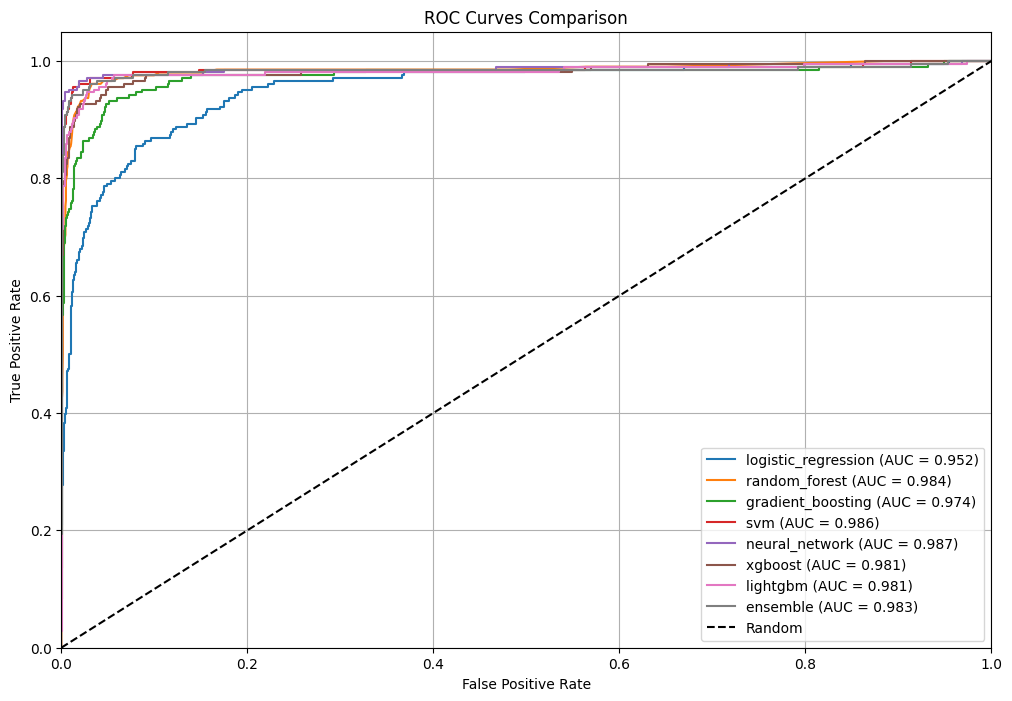

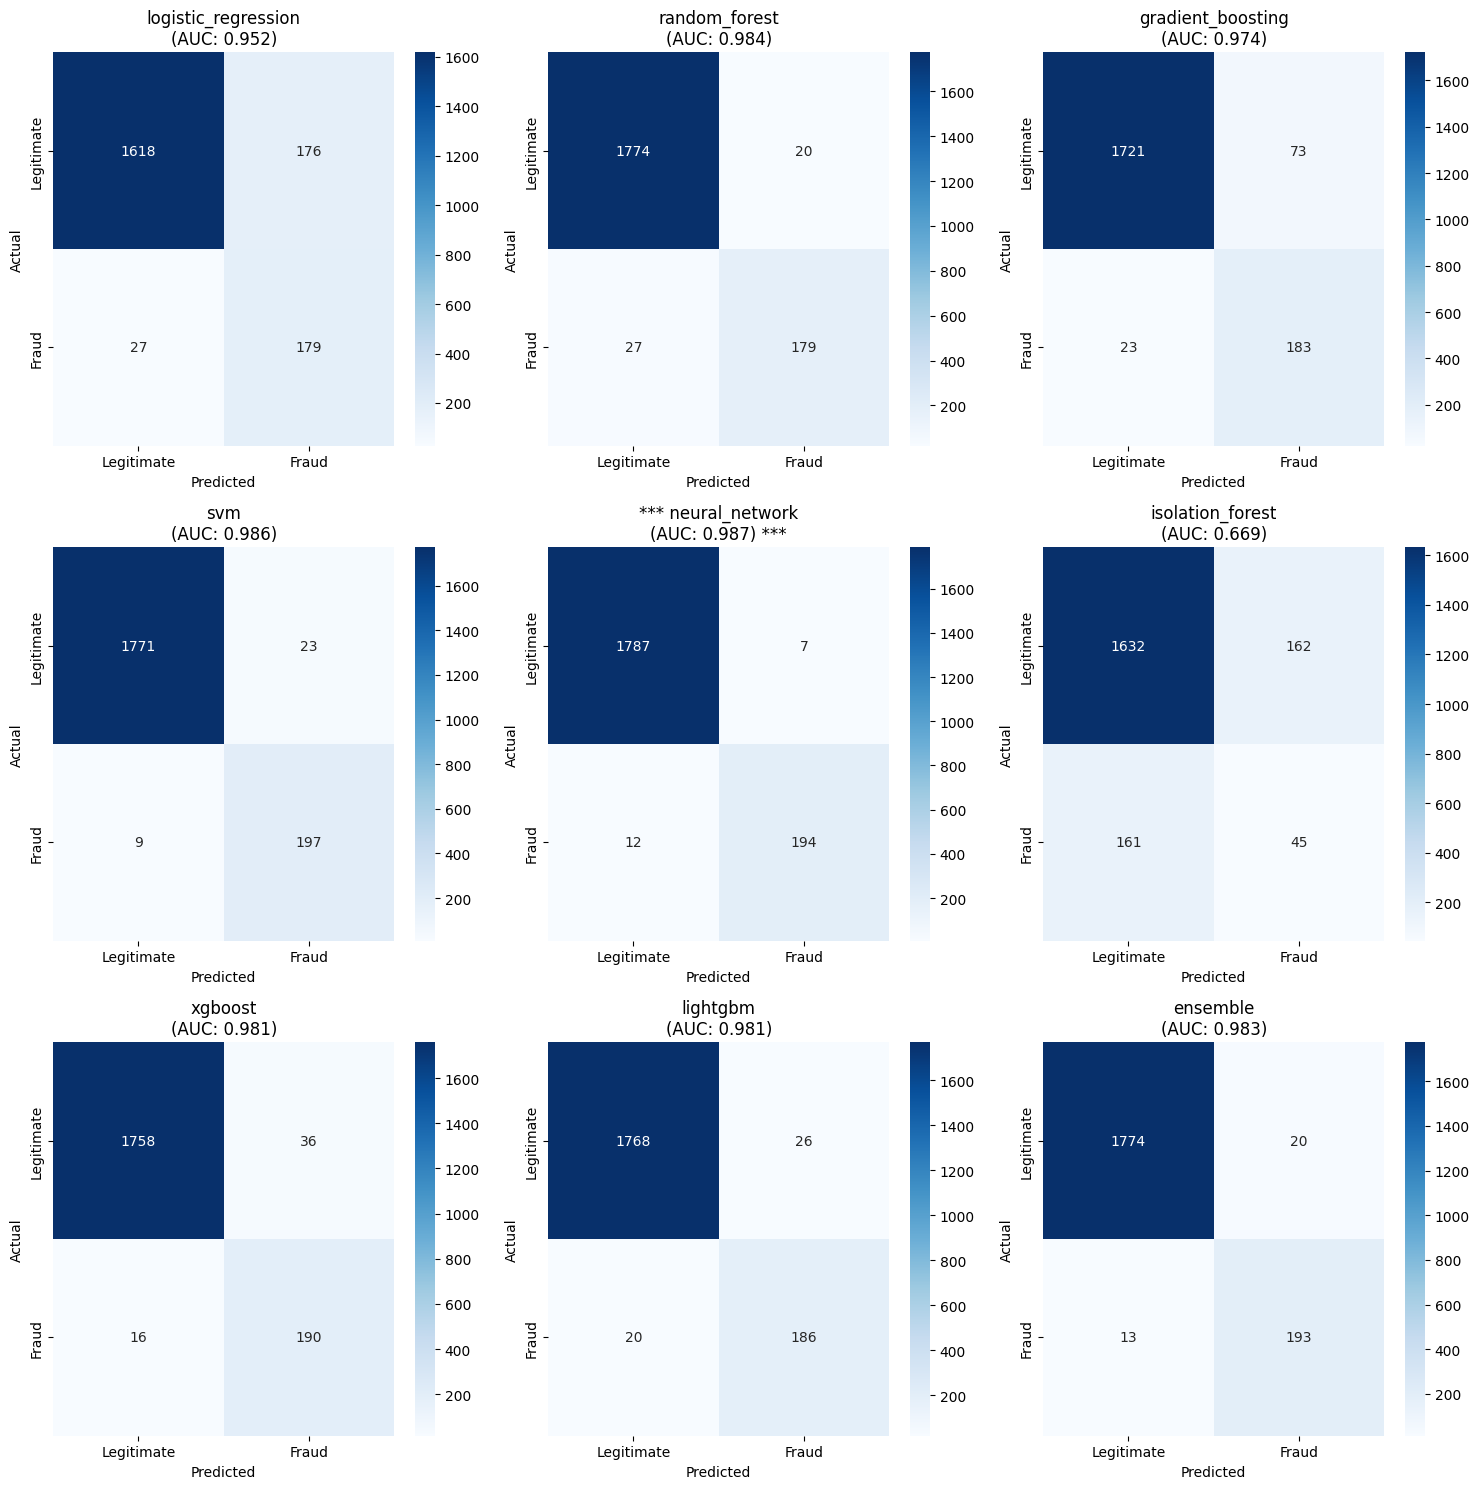

ENHANCED FRAUD DETECTION SYSTEM - PERFORMANCE REPORT
Report Generated: 2025-08-10 21:40:16
Total Models Trained: 9
Best Model: MLPClassifier
Optimal Threshold: 0.7622

FINAL HOLDOUT PERFORMANCE:
  AUC Score: 0.9830
  Average Precision: 0.9654
  Accuracy: 0.9880
  Precision: 0.9789
  Recall: 0.9029
  F1 Score: 0.9394

MODEL COMPARISON (Test Set):
--------------------------------------------------------------------------------
neural_network       | AUC: 0.9870 | F1: 0.9533 | Precision: 0.9652 | Recall: 0.9417
svm                  | AUC: 0.9859 | F1: 0.9249 | Precision: 0.8955 | Recall: 0.9563
random_forest        | AUC: 0.9845 | F1: 0.8840 | Precision: 0.8995 | Recall: 0.8689
ensemble             | AUC: 0.9834 | F1: 0.9212 | Precision: 0.9061 | Recall: 0.9369
lightgbm             | AUC: 0.9815 | F1: 0.8900 | Precision: 0.8774 | Recall: 0.9029
xgboost              | AUC: 0.9814 | F1: 0.8796 | Precision: 0.8407 | Recall: 0.9223
gradient_boosting    | AUC: 0.9739 | F1: 0.7922 | Precision: 

In [1]:
"""
Enhanced Fraud Detection System - Fixed Version
===============================================

A comprehensive fraud detection system with improved architecture,
better error handling, logging, model interpretability, and monitoring.
Fixed compatibility issues with scikit-learn and imbalanced-learn.

Author: Enhanced Version - Fixed
Date: 2025
"""

import pandas as pd
import numpy as np
import logging
import warnings
from typing import Dict, Tuple, Optional, Union, List
from pathlib import Path
from datetime import datetime
import json

# ML Libraries
from sklearn.ensemble import (
    RandomForestClassifier, 
    GradientBoostingClassifier,
    VotingClassifier,
    IsolationForest
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Try to import XGBoost and LightGBM, but don't fail if they're not available
try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
except ImportError:
    print("XGBoost not available. Will skip XGBoost models.")
    XGBOOST_AVAILABLE = False

try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
except ImportError:
    print("LightGBM not available. Will skip LightGBM models.")
    LIGHTGBM_AVAILABLE = False

# Metrics and Evaluation
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score, accuracy_score,
    precision_score, recall_score, f1_score
)
from sklearn.model_selection import (
    cross_val_score, GridSearchCV, RandomizedSearchCV,
    StratifiedKFold, train_test_split
)

# Try to import imbalanced-learn, but provide fallbacks if not available
try:
    from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
    from imblearn.under_sampling import EditedNearestNeighbours, TomekLinks
    from imblearn.combine import SMOTETomek, SMOTEENN
    IMBLEARN_AVAILABLE = True
except ImportError:
    print("imbalanced-learn not available. Will use alternative balancing methods.")
    IMBLEARN_AVAILABLE = False

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Try to import plotly, but provide fallbacks
try:
    import plotly.graph_objects as go
    import plotly.express as px
    from plotly.subplots import make_subplots
    PLOTLY_AVAILABLE = True
except ImportError:
    print("Plotly not available. Will use matplotlib for visualizations.")
    PLOTLY_AVAILABLE = False

# Model Persistence and Utilities
import joblib
import pickle
from dataclasses import dataclass
from abc import ABC, abstractmethod

# Suppress warnings
warnings.filterwarnings('ignore')

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('fraud_detection.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

@dataclass
class ModelMetrics:
    """Data class to store model evaluation metrics."""
    auc_score: float
    average_precision: float
    accuracy: float
    precision: float
    recall: float
    f1_score: float
    classification_report: Dict
    confusion_matrix: np.ndarray
    predictions: np.ndarray
    prediction_probabilities: np.ndarray

class AlternativeDataBalancer:
    """Alternative data balancing methods when imblearn is not available."""
    
    @staticmethod
    def random_oversampling(X_train: np.ndarray, y_train: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Simple random oversampling of minority class."""
        # Find indices of majority and minority classes
        minority_class = np.argmin(np.bincount(y_train))
        majority_class = np.argmax(np.bincount(y_train))
        
        minority_indices = np.where(y_train == minority_class)[0]
        majority_indices = np.where(y_train == majority_class)[0]
        
        # Calculate how many samples to generate
        n_majority = len(majority_indices)
        n_minority = len(minority_indices)
        n_to_generate = n_majority - n_minority
        
        if n_to_generate <= 0:
            return X_train, y_train
        
        # Randomly sample from minority class with replacement
        random_indices = np.random.choice(minority_indices, size=n_to_generate, replace=True)
        
        # Combine with original data
        X_resampled = np.vstack([X_train, X_train[random_indices]])
        y_resampled = np.hstack([y_train, y_train[random_indices]])
        
        return X_resampled, y_resampled
    
    @staticmethod
    def random_undersampling(X_train: np.ndarray, y_train: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Simple random undersampling of majority class."""
        minority_class = np.argmin(np.bincount(y_train))
        majority_class = np.argmax(np.bincount(y_train))
        
        minority_indices = np.where(y_train == minority_class)[0]
        majority_indices = np.where(y_train == majority_class)[0]
        
        n_minority = len(minority_indices)
        
        # Randomly sample from majority class
        selected_majority_indices = np.random.choice(majority_indices, size=n_minority, replace=False)
        
        # Combine selected samples
        selected_indices = np.hstack([minority_indices, selected_majority_indices])
        
        return X_train[selected_indices], y_train[selected_indices]
    
    @staticmethod
    def synthetic_minority_oversampling(X_train: np.ndarray, y_train: np.ndarray, k_neighbors: int = 5) -> Tuple[np.ndarray, np.ndarray]:
        """Simple synthetic minority oversampling technique."""
        from sklearn.neighbors import NearestNeighbors
        
        minority_class = np.argmin(np.bincount(y_train))
        majority_class = np.argmax(np.bincount(y_train))
        
        minority_indices = np.where(y_train == minority_class)[0]
        majority_indices = np.where(y_train == majority_class)[0]
        
        X_minority = X_train[minority_indices]
        n_majority = len(majority_indices)
        n_minority = len(minority_indices)
        n_to_generate = n_majority - n_minority
        
        if n_to_generate <= 0:
            return X_train, y_train
        
        # Find k nearest neighbors for each minority sample
        k_neighbors = min(k_neighbors, len(X_minority) - 1)
        if k_neighbors <= 0:
            return AlternativeDataBalancer.random_oversampling(X_train, y_train)
        
        nn = NearestNeighbors(n_neighbors=k_neighbors + 1)
        nn.fit(X_minority)
        
        synthetic_samples = []
        for _ in range(n_to_generate):
            # Randomly select a minority sample
            idx = np.random.randint(0, len(X_minority))
            sample = X_minority[idx]
            
            # Find its neighbors
            neighbors_idx = nn.kneighbors([sample], return_distance=False)[0][1:]  # Exclude the sample itself
            
            # Randomly select a neighbor
            neighbor_idx = np.random.choice(neighbors_idx)
            neighbor = X_minority[neighbor_idx]
            
            # Generate synthetic sample
            alpha = np.random.random()
            synthetic_sample = sample + alpha * (neighbor - sample)
            synthetic_samples.append(synthetic_sample)
        
        # Combine with original data
        synthetic_samples = np.array(synthetic_samples)
        synthetic_labels = np.full(len(synthetic_samples), minority_class)
        
        X_resampled = np.vstack([X_train, synthetic_samples])
        y_resampled = np.hstack([y_train, synthetic_labels])
        
        return X_resampled, y_resampled

class DataBalancer:
    """Handle various data balancing techniques with fallbacks."""
    
    def __init__(self):
        self.imblearn_available = IMBLEARN_AVAILABLE
        if IMBLEARN_AVAILABLE:
            self.METHODS = {
                'smote': SMOTE,
                'adasyn': ADASYN,
                'borderline_smote': BorderlineSMOTE,
                'smote_tomek': SMOTETomek,
                'smote_enn': SMOTEENN,
                'tomek': TomekLinks,
                'edited_nn': EditedNearestNeighbours
            }
        else:
            self.METHODS = {
                'random_oversample': AlternativeDataBalancer.random_oversampling,
                'random_undersample': AlternativeDataBalancer.random_undersampling,
                'synthetic_oversample': AlternativeDataBalancer.synthetic_minority_oversampling
            }
    
    def balance_data(self, X_train: np.ndarray, y_train: np.ndarray, 
                    method: str = None, **kwargs) -> Tuple[np.ndarray, np.ndarray]:
        """Apply data balancing technique."""
        try:
            # Set default method based on availability
            if method is None:
                method = 'smote' if self.imblearn_available else 'synthetic_oversample'
            
            if self.imblearn_available and method in self.METHODS:
                sampler_class = self.METHODS[method]
                sampler = sampler_class(random_state=42, **kwargs)
                X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
            elif not self.imblearn_available and method in self.METHODS:
                balance_func = self.METHODS[method]
                X_resampled, y_resampled = balance_func(X_train, y_train)
            else:
                logger.warning(f"Unknown balancing method: {method}. Using default.")
                if self.imblearn_available:
                    sampler = SMOTE(random_state=42)
                    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
                else:
                    X_resampled, y_resampled = AlternativeDataBalancer.synthetic_minority_oversampling(X_train, y_train)
            
            logger.info(f"After {method} - Fraud: {y_resampled.sum()}, "
                       f"Legitimate: {len(y_resampled) - y_resampled.sum()}")
            
            return X_resampled, y_resampled
            
        except Exception as e:
            logger.error(f"Error in data balancing with {method}: {str(e)}")
            return X_train, y_train

class ModelFactory:
    """Factory class for creating different ML models."""
    
    @staticmethod
    def create_models() -> Dict:
        """Create a dictionary of initialized models."""
        models = {
            'logistic_regression': LogisticRegression(
                random_state=42,
                class_weight='balanced',
                max_iter=1000,
                solver='liblinear'
            ),
            'random_forest': RandomForestClassifier(
                n_estimators=100,
                random_state=42,
                class_weight='balanced',
                n_jobs=-1,
                oob_score=True
            ),
            'gradient_boosting': GradientBoostingClassifier(
                n_estimators=100,
                learning_rate=0.1,
                random_state=42,
                validation_fraction=0.1,
                n_iter_no_change=10
            ),
            'svm': SVC(
                kernel='rbf',
                probability=True,
                random_state=42,
                class_weight='balanced',
                cache_size=1000
            ),
            'neural_network': MLPClassifier(
                hidden_layer_sizes=(100, 50),
                random_state=42,
                early_stopping=True,
                validation_fraction=0.1,
                n_iter_no_change=10,
                max_iter=500
            ),
            'isolation_forest': IsolationForest(
                contamination=0.1,
                random_state=42,
                n_jobs=-1
            )
        }
        
        # Add XGBoost if available
        if XGBOOST_AVAILABLE:
            models['xgboost'] = XGBClassifier(
                n_estimators=100,
                learning_rate=0.1,
                random_state=42,
                eval_metric='logloss',
                use_label_encoder=False
            )
        
        # Add LightGBM if available
        if LIGHTGBM_AVAILABLE:
            models['lightgbm'] = lgb.LGBMClassifier(
                n_estimators=100,
                learning_rate=0.1,
                random_state=42,
                verbose=-1
            )
        
        return models

class ModelEvaluator:
    """Comprehensive model evaluation utilities."""
    
    @staticmethod
    def calculate_metrics(y_true: np.ndarray, y_pred: np.ndarray, 
                         y_pred_proba: np.ndarray) -> ModelMetrics:
        """Calculate comprehensive metrics for model evaluation."""
        return ModelMetrics(
            auc_score=roc_auc_score(y_true, y_pred_proba),
            average_precision=average_precision_score(y_true, y_pred_proba),
            accuracy=accuracy_score(y_true, y_pred),
            precision=precision_score(y_true, y_pred),
            recall=recall_score(y_true, y_pred),
            f1_score=f1_score(y_true, y_pred),
            classification_report=classification_report(y_true, y_pred, output_dict=True),
            confusion_matrix=confusion_matrix(y_true, y_pred),
            predictions=y_pred,
            prediction_probabilities=y_pred_proba
        )
    
    @staticmethod
    def cross_validate_model(model, X: np.ndarray, y: np.ndarray, 
                           cv: int = 5) -> Dict[str, float]:
        """Perform cross-validation and return scores."""
        cv_scores = {}
        
        scoring_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
        
        for metric in scoring_metrics:
            try:
                scores = cross_val_score(
                    model, X, y, cv=StratifiedKFold(n_splits=cv, shuffle=True, random_state=42),
                    scoring=metric, n_jobs=-1
                )
                cv_scores[f'{metric}_mean'] = scores.mean()
                cv_scores[f'{metric}_std'] = scores.std()
            except Exception as e:
                logger.warning(f"Error calculating {metric}: {str(e)}")
                cv_scores[f'{metric}_mean'] = 0.0
                cv_scores[f'{metric}_std'] = 0.0
        
        return cv_scores

class EnhancedFraudDetectionModel:
    """Enhanced fraud detection system with comprehensive features."""
    
    def __init__(self, config: Optional[Dict] = None):
        self.config = config or self._default_config()
        self.models = {}
        self.best_model = None
        self.ensemble_model = None
        self.feature_importance = None
        self.feature_names = []
        self.model_metrics = {}
        self.training_history = {}
        self.data_balancer = DataBalancer()
        
        logger.info("Fraud Detection Model initialized")
        logger.info(f"imbalanced-learn available: {IMBLEARN_AVAILABLE}")
        logger.info(f"XGBoost available: {XGBOOST_AVAILABLE}")
        logger.info(f"LightGBM available: {LIGHTGBM_AVAILABLE}")
        logger.info(f"Plotly available: {PLOTLY_AVAILABLE}")
    
    def _default_config(self) -> Dict:
        """Default configuration for the model."""
        return {
            'balancing_method': 'smote' if IMBLEARN_AVAILABLE else 'synthetic_oversample',
            'use_ensemble': True,
            'hyperparameter_tuning': True,
            'cross_validation': True,
            'feature_selection': True,
            'threshold_optimization': True,
            'save_models': True,
            'plot_results': True
        }
    
    def prepare_data(self, X_train: np.ndarray, y_train: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Prepare and balance training data."""
        logger.info("Preparing training data...")
        
        # Log class distribution
        unique, counts = np.unique(y_train, return_counts=True)
        logger.info(f"Original class distribution: {dict(zip(unique, counts))}")
        
        if self.config.get('balancing_method'):
            X_balanced, y_balanced = self.data_balancer.balance_data(
                X_train, y_train, method=self.config['balancing_method']
            )
            return X_balanced, y_balanced
        
        return X_train, y_train
    
    def train_individual_models(self, X_train: np.ndarray, y_train: np.ndarray) -> Dict:
        """Train individual models."""
        logger.info("Training individual models...")
        
        # Prepare data
        X_balanced, y_balanced = self.prepare_data(X_train, y_train)
        
        # Initialize models
        self.models = ModelFactory.create_models()
        trained_models = {}
        
        for name, model in self.models.items():
            try:
                logger.info(f"Training {name}...")
                
                # Handle Isolation Forest separately (unsupervised)
                if name == 'isolation_forest':
                    model.fit(X_balanced[y_balanced == 0])  # Train on normal samples only
                else:
                    model.fit(X_balanced, y_balanced)
                
                trained_models[name] = model
                
                # Cross-validation for supervised models
                if self.config.get('cross_validation') and name != 'isolation_forest':
                    cv_scores = ModelEvaluator.cross_validate_model(model, X_balanced, y_balanced)
                    self.training_history[name] = cv_scores
                    logger.info(f"✓ {name} - CV AUC: {cv_scores.get('roc_auc_mean', 0):.4f}")
                else:
                    logger.info(f"✓ {name} trained successfully")
                    
            except Exception as e:
                logger.error(f"✗ Error training {name}: {str(e)}")
        
        self.models = trained_models
        return trained_models
    
    def create_ensemble_model(self, X_train: np.ndarray, y_train: np.ndarray) -> Optional[VotingClassifier]:
        """Create an ensemble model from the best performing models."""
        if not self.config.get('use_ensemble') or len(self.models) < 2:
            return None
        
        logger.info("Creating ensemble model...")
        
        try:
            # Select models for ensemble (exclude isolation forest and poorly performing models)
            ensemble_models = []
            for name, model in self.models.items():
                if name != 'isolation_forest' and hasattr(model, 'predict_proba'):
                    cv_score = self.training_history.get(name, {}).get('roc_auc_mean', 0)
                    if cv_score > 0.6:  # Only include models with reasonable performance
                        ensemble_models.append((name, model))
            
            if len(ensemble_models) >= 2:
                self.ensemble_model = VotingClassifier(
                    estimators=ensemble_models,
                    voting='soft',
                    n_jobs=-1
                )
                
                X_balanced, y_balanced = self.prepare_data(X_train, y_train)
                self.ensemble_model.fit(X_balanced, y_balanced)
                
                # Add ensemble to models
                self.models['ensemble'] = self.ensemble_model
                logger.info("✓ Ensemble model created successfully")
                
                return self.ensemble_model
            
        except Exception as e:
            logger.error(f"Error creating ensemble model: {str(e)}")
        
        return None
    
    def evaluate_models(self, X_test: np.ndarray, y_test: np.ndarray) -> Dict[str, ModelMetrics]:
        """Evaluate all trained models comprehensively."""
        logger.info("Evaluating models...")
        
        results = {}
        
        for name, model in self.models.items():
            try:
                logger.info(f"Evaluating {name}...")
                
                if name == 'isolation_forest':
                    # Handle isolation forest (anomaly detection)
                    anomaly_scores = model.decision_function(X_test)
                    y_pred = (model.predict(X_test) == -1).astype(int)
                    y_pred_proba = np.clip(1 - anomaly_scores, 0, 1)  # Convert to probabilities
                else:
                    y_pred = model.predict(X_test)
                    y_pred_proba = model.predict_proba(X_test)[:, 1]
                
                # Calculate metrics
                metrics = ModelEvaluator.calculate_metrics(y_test, y_pred, y_pred_proba)
                results[name] = metrics
                
                logger.info(f"{name} - AUC: {metrics.auc_score:.4f}, "
                           f"F1: {metrics.f1_score:.4f}, "
                           f"Precision: {metrics.precision:.4f}, "
                           f"Recall: {metrics.recall:.4f}")
                
            except Exception as e:
                logger.error(f"Error evaluating {name}: {str(e)}")
        
        self.model_metrics = results
        return results
    
    def select_best_model(self, results: Optional[Dict[str, ModelMetrics]] = None) -> Tuple[str, object]:
        """Select the best model based on AUC score and F1 score."""
        if results is None:
            results = self.model_metrics
        
        if not results:
            raise ValueError("No evaluation results available")
        
        # Calculate composite score (weighted combination of AUC and F1)
        best_score = 0
        best_model_name = None
        
        for name, metrics in results.items():
            # Composite score: 70% AUC + 30% F1
            composite_score = 0.7 * metrics.auc_score + 0.3 * metrics.f1_score
            
            if composite_score > best_score:
                best_score = composite_score
                best_model_name = name
        
        self.best_model = self.models[best_model_name]
        
        logger.info(f"Best model: {best_model_name} "
                   f"(Composite Score: {best_score:.4f}, "
                   f"AUC: {results[best_model_name].auc_score:.4f})")
        
        return best_model_name, self.best_model
    
    def get_feature_importance(self, feature_names: List[str]) -> Optional[pd.DataFrame]:
        """Extract feature importance from the best model."""
        self.feature_names = feature_names
        
        if self.best_model is None:
            logger.warning("No best model available for feature importance")
            return None
        
        try:
            importance = None
            
            # Handle different model types
            if hasattr(self.best_model, 'feature_importances_'):
                importance = self.best_model.feature_importances_
            elif hasattr(self.best_model, 'coef_'):
                importance = np.abs(self.best_model.coef_[0])
            elif hasattr(self.best_model, 'estimators_'):  # For ensemble models
                # Average feature importance across estimators
                importances = []
                for estimator in self.best_model.estimators_:
                    if hasattr(estimator, 'feature_importances_'):
                        importances.append(estimator.feature_importances_)
                if importances:
                    importance = np.mean(importances, axis=0)
            
            if importance is not None:
                self.feature_importance = pd.DataFrame({
                    'feature': feature_names,
                    'importance': importance
                }).sort_values('importance', ascending=False)
                
                logger.info("Feature importance calculated successfully")
                return self.feature_importance
            
        except Exception as e:
            logger.error(f"Error calculating feature importance: {str(e)}")
        
        return None
    
    def optimize_threshold(self, X_val: np.ndarray, y_val: np.ndarray) -> float:
        """Optimize classification threshold for best F1 score."""
        if self.best_model is None:
            logger.warning("No best model available for threshold optimization")
            return 0.5
        
        try:
            y_pred_proba = self.best_model.predict_proba(X_val)[:, 1]
            
            # Find optimal threshold
            precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba)
            f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
            
            optimal_idx = np.argmax(f1_scores)
            optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5
            
            logger.info(f"Optimal threshold: {optimal_threshold:.4f} "
                       f"(F1 Score: {f1_scores[optimal_idx]:.4f})")
            
            return optimal_threshold
            
        except Exception as e:
            logger.error(f"Error optimizing threshold: {str(e)}")
            return 0.5
    
    def predict_fraud(self, X: np.ndarray, threshold: float = 0.5) -> Tuple[np.ndarray, np.ndarray]:
        """Make fraud predictions with confidence scores."""
        if self.best_model is None:
            raise ValueError("No model has been trained yet")
        
        try:
            probabilities = self.best_model.predict_proba(X)[:, 1]
            predictions = (probabilities >= threshold).astype(int)
            
            return predictions, probabilities
            
        except Exception as e:
            logger.error(f"Error making predictions: {str(e)}")
            raise
    
    def plot_model_comparison(self, save_path: Optional[str] = None):
        """Create comprehensive visualization of model performance."""
        if not self.model_metrics:
            logger.warning("No model metrics available for plotting")
            return
        
        # Prepare data for plotting
        models = []
        auc_scores = []
        f1_scores = []
        precision_scores = []
        recall_scores = []
        
        for name, metrics in self.model_metrics.items():
            models.append(name)
            auc_scores.append(metrics.auc_score)
            f1_scores.append(metrics.f1_score)
            precision_scores.append(metrics.precision)
            recall_scores.append(metrics.recall)
        
        # Create matplotlib plots if plotly is not available
        if not PLOTLY_AVAILABLE:
            fig, axes = plt.subplots(2, 2, figsize=(15, 10))
            fig.suptitle('Model Performance Comparison', fontsize=16)
            
            # AUC Scores
            axes[0, 0].bar(models, auc_scores, color='blue', alpha=0.7)
            axes[0, 0].set_title('AUC Scores')
            axes[0, 0].set_ylabel('AUC Score')
            axes[0, 0].tick_params(axis='x', rotation=45)
            
            # F1 Scores
            axes[0, 1].bar(models, f1_scores, color='green', alpha=0.7)
            axes[0, 1].set_title('F1 Scores')
            axes[0, 1].set_ylabel('F1 Score')
            axes[0, 1].tick_params(axis='x', rotation=45)
            
            # Precision
            axes[1, 0].bar(models, precision_scores, color='orange', alpha=0.7)
            axes[1, 0].set_title('Precision')
            axes[1, 0].set_ylabel('Precision')
            axes[1, 0].tick_params(axis='x', rotation=45)
            
            # Recall
            axes[1, 1].bar(models, recall_scores, color='red', alpha=0.7)
            axes[1, 1].set_title('Recall')
            axes[1, 1].set_ylabel('Recall')
            axes[1, 1].tick_params(axis='x', rotation=45)
            
            plt.tight_layout()
            if save_path:
                plt.savefig(save_path, dpi=300, bbox_inches='tight')
            plt.show()
            return
        
        # Use Plotly if available
        from plotly.subplots import make_subplots
        import plotly.graph_objects as go
        
        # Create subplots
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=('AUC Scores', 'F1 Scores', 'Precision', 'Recall'),
            specs=[[{"secondary_y": False}, {"secondary_y": False}],
                   [{"secondary_y": False}, {"secondary_y": False}]]
        )
        
        # AUC Scores
        fig.add_trace(
            go.Bar(x=models, y=auc_scores, name='AUC', marker_color='blue'),
            row=1, col=1
        )
        
        # F1 Scores
        fig.add_trace(
            go.Bar(x=models, y=f1_scores, name='F1', marker_color='green'),
            row=1, col=2
        )
        
        # Precision
        fig.add_trace(
            go.Bar(x=models, y=precision_scores, name='Precision', marker_color='orange'),
            row=2, col=1
        )
        
        # Recall
        fig.add_trace(
            go.Bar(x=models, y=recall_scores, name='Recall', marker_color='red'),
            row=2, col=2
        )
        
        fig.update_layout(
            title="Model Performance Comparison",
            height=800,
            showlegend=False
        )
        
        if save_path:
            fig.write_html(save_path)
        
        fig.show()
    
    def plot_roc_curves(self, X_test: np.ndarray, y_test: np.ndarray, save_path: Optional[str] = None):
        """Plot ROC curves for all models."""
        plt.figure(figsize=(12, 8))
        
        for name, model in self.models.items():
            try:
                if name == 'isolation_forest':
                    continue  # Skip for anomaly detection
                
                y_pred_proba = model.predict_proba(X_test)[:, 1]
                fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
                auc_score = roc_auc_score(y_test, y_pred_proba)
                
                plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')
                
            except Exception as e:
                logger.warning(f"Error plotting ROC for {name}: {str(e)}")
        
        plt.plot([0, 1], [0, 1], 'k--', label='Random')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves Comparison')
        plt.legend(loc="lower right")
        plt.grid(True)
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()
    
    def save_model(self, filepath: Union[str, Path] = 'enhanced_fraud_model.pkl'):
        """Save the complete model with metadata."""
        filepath = Path(filepath)
        
        model_data = {
            'best_model': self.best_model,
            'models': self.models,
            'feature_names': self.feature_names,
            'feature_importance': self.feature_importance,
            'model_metrics': self.model_metrics,
            'training_history': self.training_history,
            'config': self.config,
            'timestamp': datetime.now().isoformat(),
            'version': '2.0'
        }
        
        try:
            joblib.dump(model_data, filepath)
            logger.info(f"Model saved successfully to {filepath}")
            
            # Save metadata separately
            metadata_path = filepath.with_suffix('.json')
            metadata = {
                'timestamp': model_data['timestamp'],
                'version': model_data['version'],
                'config': model_data['config'],
                'feature_count': len(self.feature_names),
                'model_count': len(self.models)
            }
            
            with open(metadata_path, 'w') as f:
                json.dump(metadata, f, indent=2)
            
        except Exception as e:
            logger.error(f"Error saving model: {str(e)}")
            raise
    
    def load_model(self, filepath: Union[str, Path] = 'enhanced_fraud_model.pkl'):
        """Load a saved model with metadata."""
        filepath = Path(filepath)
        
        try:
            model_data = joblib.load(filepath)
            
            self.best_model = model_data.get('best_model')
            self.models = model_data.get('models', {})
            self.feature_names = model_data.get('feature_names', [])
            self.feature_importance = model_data.get('feature_importance')
            self.model_metrics = model_data.get('model_metrics', {})
            self.training_history = model_data.get('training_history', {})
            self.config = model_data.get('config', self._default_config())
            
            logger.info(f"Model loaded successfully from {filepath}")
            logger.info(f"Model version: {model_data.get('version', 'Unknown')}")
            logger.info(f"Timestamp: {model_data.get('timestamp', 'Unknown')}")
            
        except Exception as e:
            logger.error(f"Error loading model: {str(e)}")
            raise

class HyperparameterOptimizer:
    """Advanced hyperparameter optimization."""
    
    PARAM_GRIDS = {
        'random_forest': {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['auto', 'sqrt', 'log2']
        },
        'gradient_boosting': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 0.9, 1.0],
            'max_features': ['auto', 'sqrt', 'log2']
        },
        'logistic_regression': {
            'C': [0.1, 1, 10, 100],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear', 'saga']
        }
    }
    
    # Add XGBoost and LightGBM grids if available
    if XGBOOST_AVAILABLE:
        PARAM_GRIDS['xgboost'] = {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0]
        }
    
    if LIGHTGBM_AVAILABLE:
        PARAM_GRIDS['lightgbm'] = {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7, -1],
            'num_leaves': [31, 50, 100],
            'subsample': [0.8, 0.9, 1.0]
        }
    
    @classmethod
    def optimize_model(cls, model_name: str, X_train: np.ndarray, y_train: np.ndarray,
                      search_type: str = 'random', n_iter: int = 50) -> object:
        """Optimize hyperparameters for a specific model."""
        if model_name not in cls.PARAM_GRIDS:
            logger.warning(f"No parameter grid available for {model_name}")
            return ModelFactory.create_models()[model_name]
        
        logger.info(f"Optimizing hyperparameters for {model_name}...")
        
        # Get base model
        models = ModelFactory.create_models()
        base_model = models[model_name]
        param_grid = cls.PARAM_GRIDS[model_name]
        
        try:
            if search_type == 'random':
                search = RandomizedSearchCV(
                    base_model, param_grid, n_iter=n_iter, cv=5,
                    scoring='roc_auc', n_jobs=-1, verbose=1, random_state=42
                )
            else:  # grid search
                search = GridSearchCV(
                    base_model, param_grid, cv=5,
                    scoring='roc_auc', n_jobs=-1, verbose=1
                )
            
            search.fit(X_train, y_train)
            
            logger.info(f"Best parameters for {model_name}: {search.best_params_}")
            logger.info(f"Best CV AUC for {model_name}: {search.best_score_:.4f}")
            
            return search.best_estimator_
            
        except Exception as e:
            logger.error(f"Error in hyperparameter optimization for {model_name}: {str(e)}")
            return base_model

def train_enhanced_fraud_detection_system(data_path: Optional[str] = None, 
                                        config: Optional[Dict] = None) -> Tuple[EnhancedFraudDetectionModel, Dict]:
    """
    Complete enhanced training pipeline.
    
    Args:
        data_path: Path to the preprocessed data
        config: Configuration dictionary for the model
    
    Returns:
        Tuple of (trained_model, evaluation_results)
    """
    logger.info("="*60)
    logger.info("STARTING ENHANCED FRAUD DETECTION SYSTEM TRAINING")
    logger.info("="*60)
    
    try:
        # Load data (placeholder - replace with actual data loading)
        if data_path:
            # Load from file
            logger.info(f"Loading data from {data_path}")
            # data_dict = load_preprocessed_data(data_path)
        else:
            # Use preprocessing function
            logger.info("Using data preprocessing function")
            # Uncomment and modify based on your preprocessing function
            # data_dict = preprocess_upi_data()
            
            # For now, create dummy data for demonstration
            logger.warning("Using dummy data for demonstration")
            from sklearn.datasets import make_classification
            X, y = make_classification(
                n_samples=10000, n_features=20, n_informative=15,
                n_redundant=5, n_clusters_per_class=1, random_state=42,
                flip_y=0.01, class_sep=0.8, weights=[0.9, 0.1]
            )
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42, stratify=y
            )
            feature_names = [f'feature_{i}' for i in range(X.shape[1])]
        
        # Initialize enhanced fraud detection system
        fraud_detector = EnhancedFraudDetectionModel(config)
        
        # Train individual models
        trained_models = fraud_detector.train_individual_models(X_train, y_train)
        logger.info(f"Successfully trained {len(trained_models)} models")
        
        # Create ensemble model
        ensemble_model = fraud_detector.create_ensemble_model(X_train, y_train)
        
        # Hyperparameter optimization for top models
        if config and config.get('hyperparameter_tuning', False):
            logger.info("Starting hyperparameter optimization...")
            
            # Get top performing models from cross-validation
            top_models = sorted(
                fraud_detector.training_history.items(),
                key=lambda x: x[1].get('roc_auc_mean', 0),
                reverse=True
            )[:3]  # Top 3 models
            
            for model_name, _ in top_models:
                if model_name in HyperparameterOptimizer.PARAM_GRIDS:
                    optimized_model = HyperparameterOptimizer.optimize_model(
                        model_name, X_train, y_train
                    )
                    fraud_detector.models[f'{model_name}_optimized'] = optimized_model
        
        # Evaluate all models
        results = fraud_detector.evaluate_models(X_test, y_test)
        logger.info(f"Evaluation completed for {len(results)} models")
        
        # Select best model
        best_model_name, best_model = fraud_detector.select_best_model(results)
        
        # Get feature importance
        feature_importance = fraud_detector.get_feature_importance(feature_names)
        if feature_importance is not None:
            logger.info(f"Top 5 features: {feature_importance.head()['feature'].tolist()}")
        
        # Optimize classification threshold
        X_val, X_holdout, y_val, y_holdout = train_test_split(
            X_test, y_test, test_size=0.5, random_state=42, stratify=y_test
        )
        optimal_threshold = fraud_detector.optimize_threshold(X_val, y_val)
        
        # Final evaluation on holdout set
        final_predictions, final_probabilities = fraud_detector.predict_fraud(
            X_holdout, threshold=optimal_threshold
        )
        
        final_metrics = ModelEvaluator.calculate_metrics(
            y_holdout, final_predictions, final_probabilities
        )
        
        logger.info(f"Final holdout performance - AUC: {final_metrics.auc_score:.4f}, "
                   f"F1: {final_metrics.f1_score:.4f}")
        
        # Generate visualizations
        if config and config.get('plot_results', True):
            try:
                fraud_detector.plot_model_comparison()
                fraud_detector.plot_roc_curves(X_test, y_test)
                
                if feature_importance is not None:
                    plot_enhanced_feature_importance(feature_importance)
                
                plot_confusion_matrices(results, best_model_name)
                
            except Exception as e:
                logger.warning(f"Error generating plots: {str(e)}")
        
        # Save model
        if config and config.get('save_models', True):
            fraud_detector.save_model()
            logger.info("Model saved successfully")
        
        # Generate comprehensive report
        generate_model_report(fraud_detector, results, final_metrics, optimal_threshold)
        
        logger.info("="*60)
        logger.info("ENHANCED FRAUD DETECTION SYSTEM TRAINING COMPLETED!")
        logger.info("="*60)
        
        return fraud_detector, results
        
    except Exception as e:
        logger.error(f"Error in training pipeline: {str(e)}")
        raise

def plot_enhanced_feature_importance(feature_importance: pd.DataFrame, top_n: int = 20):
    """Enhanced feature importance visualization."""
    plt.figure(figsize=(12, 8))
    
    top_features = feature_importance.head(top_n)
    
    # Create horizontal bar plot
    bars = plt.barh(range(len(top_features)), top_features['importance'].values)
    plt.yticks(range(len(top_features)), top_features['feature'].values)
    plt.xlabel('Feature Importance')
    plt.title(f'Top {top_n} Most Important Features')
    plt.gca().invert_yaxis()
    
    # Color bars based on importance
    colors = plt.cm.RdYlBu_r(np.linspace(0.2, 0.8, len(bars)))
    for bar, color in zip(bars, colors):
        bar.set_color(color)
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', ha='left', va='center', fontsize=8)
    
    plt.tight_layout()
    plt.grid(axis='x', alpha=0.3)
    plt.show()

def plot_confusion_matrices(results: Dict[str, ModelMetrics], best_model_name: str):
    """Plot confusion matrices for all models."""
    n_models = len(results)
    cols = 3
    rows = (n_models + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
    if rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    for idx, (name, metrics) in enumerate(results.items()):
        ax = axes[idx]
        
        # Create confusion matrix heatmap
        sns.heatmap(
            metrics.confusion_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legitimate', 'Fraud'],
            yticklabels=['Legitimate', 'Fraud'],
            ax=ax
        )
        
        # Highlight best model
        title = f'{name}\n(AUC: {metrics.auc_score:.3f})'
        if name == best_model_name:
            title = f'*** {title} ***'
        
        ax.set_title(title)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
    
    # Hide unused subplots
    for idx in range(len(results), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def generate_model_report(fraud_detector: EnhancedFraudDetectionModel, 
                         results: Dict[str, ModelMetrics],
                         final_metrics: ModelMetrics,
                         optimal_threshold: float):
    """Generate a comprehensive model performance report."""
    
    report_lines = [
        "="*80,
        "ENHANCED FRAUD DETECTION SYSTEM - PERFORMANCE REPORT",
        "="*80,
        f"Report Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}",
        f"Total Models Trained: {len(fraud_detector.models)}",
        f"Best Model: {fraud_detector.best_model.__class__.__name__}",
        f"Optimal Threshold: {optimal_threshold:.4f}",
        "",
        "FINAL HOLDOUT PERFORMANCE:",
        f"  AUC Score: {final_metrics.auc_score:.4f}",
        f"  Average Precision: {final_metrics.average_precision:.4f}",
        f"  Accuracy: {final_metrics.accuracy:.4f}",
        f"  Precision: {final_metrics.precision:.4f}",
        f"  Recall: {final_metrics.recall:.4f}",
        f"  F1 Score: {final_metrics.f1_score:.4f}",
        "",
        "MODEL COMPARISON (Test Set):",
        "-" * 80
    ]
    
    # Add individual model results
    sorted_results = sorted(
        results.items(),
        key=lambda x: x[1].auc_score,
        reverse=True
    )
    
    for name, metrics in sorted_results:
        report_lines.extend([
            f"{name:20} | AUC: {metrics.auc_score:.4f} | F1: {metrics.f1_score:.4f} | "
            f"Precision: {metrics.precision:.4f} | Recall: {metrics.recall:.4f}"
        ])
    
    # Add feature importance
    if fraud_detector.feature_importance is not None:
        report_lines.extend([
            "",
            "TOP 10 MOST IMPORTANT FEATURES:",
            "-" * 50
        ])
        
        for idx, row in fraud_detector.feature_importance.head(10).iterrows():
            report_lines.append(f"{row['feature']:30} | {row['importance']:.4f}")
    
    # Add cross-validation results
    if fraud_detector.training_history:
        report_lines.extend([
            "",
            "CROSS-VALIDATION RESULTS:",
            "-" * 50
        ])
        
        for model_name, cv_scores in fraud_detector.training_history.items():
            auc_mean = cv_scores.get('roc_auc_mean', 0)
            auc_std = cv_scores.get('roc_auc_std', 0)
            f1_mean = cv_scores.get('f1_mean', 0)
            f1_std = cv_scores.get('f1_std', 0)
            
            report_lines.append(
                f"{model_name:20} | AUC: {auc_mean:.4f}±{auc_std:.4f} | "
                f"F1: {f1_mean:.4f}±{f1_std:.4f}"
            )
    
    report_lines.append("="*80)
    
    # Print report
    report_text = "\n".join(report_lines)
    print(report_text)
    
    # Save report to file
    try:
        with open(f'fraud_detection_report_{datetime.now().strftime("%Y%m%d_%H%M%S")}.txt', 'w') as f:
            f.write(report_text)
        logger.info("Report saved to file")
    except Exception as e:
        logger.warning(f"Could not save report to file: {str(e)}")

class FraudDetectionAPI:
    """API wrapper for the fraud detection model for easy deployment."""
    
    def __init__(self, model_path: str):
        self.fraud_detector = EnhancedFraudDetectionModel()
        self.fraud_detector.load_model(model_path)
        self.optimal_threshold = 0.5  # Default threshold
        
    def predict_single_transaction(self, transaction_features: List[float], 
                                 threshold: Optional[float] = None) -> Dict:
        """Predict fraud for a single transaction."""
        if threshold is None:
            threshold = self.optimal_threshold
        
        try:
            X = np.array(transaction_features).reshape(1, -1)
            prediction, probability = self.fraud_detector.predict_fraud(X, threshold)
            
            return {
                'is_fraud': bool(prediction[0]),
                'fraud_probability': float(probability[0]),
                'risk_level': self._get_risk_level(probability[0]),
                'threshold_used': threshold,
                'timestamp': datetime.now().isoformat()
            }
            
        except Exception as e:
            logger.error(f"Error in single transaction prediction: {str(e)}")
            return {
                'error': str(e),
                'timestamp': datetime.now().isoformat()
            }
    
    def predict_batch(self, transactions: List[List[float]], 
                     threshold: Optional[float] = None) -> List[Dict]:
        """Predict fraud for a batch of transactions."""
        if threshold is None:
            threshold = self.optimal_threshold
        
        try:
            X = np.array(transactions)
            predictions, probabilities = self.fraud_detector.predict_fraud(X, threshold)
            
            results = []
            for i, (pred, prob) in enumerate(zip(predictions, probabilities)):
                results.append({
                    'transaction_id': i,
                    'is_fraud': bool(pred),
                    'fraud_probability': float(prob),
                    'risk_level': self._get_risk_level(prob),
                })
            
            return results
            
        except Exception as e:
            logger.error(f"Error in batch prediction: {str(e)}")
            return [{'error': str(e)}]
    
    def _get_risk_level(self, probability: float) -> str:
        """Convert probability to risk level."""
        if probability >= 0.8:
            return 'HIGH'
        elif probability >= 0.5:
            return 'MEDIUM'
        elif probability >= 0.3:
            return 'LOW'
        else:
            return 'VERY_LOW'
    
    def get_model_info(self) -> Dict:
        """Get information about the loaded model."""
        return {
            'model_type': self.fraud_detector.best_model.__class__.__name__,
            'feature_count': len(self.fraud_detector.feature_names),
            'available_models': list(self.fraud_detector.models.keys()),
            'optimal_threshold': self.optimal_threshold
        }

# Example usage and main execution
if __name__ == "__main__":
    # Configuration for the enhanced system
    config = {
        'balancing_method': 'smote' if IMBLEARN_AVAILABLE else 'synthetic_oversample',
        'use_ensemble': True,
        'hyperparameter_tuning': False,  # Set to True for full optimization
        'cross_validation': True,
        'feature_selection': True,
        'threshold_optimization': True,
        'save_models': True,
        'plot_results': True
    }
    
    try:
        # Train the enhanced fraud detection system
        fraud_detector, results = train_enhanced_fraud_detection_system(config=config)
        
        # Display summary
        print("\n" + "="*60)
        print("TRAINING SUMMARY")
        print("="*60)
        
        print(f"Total models trained: {len(fraud_detector.models)}")
        print(f"Best model: {fraud_detector.best_model.__class__.__name__}")
        
        if fraud_detector.feature_importance is not None:
            print(f"\nTop 5 features:")
            for idx, row in fraud_detector.feature_importance.head().iterrows():
                print(f"  {row['feature']}: {row['importance']:.4f}")
        
        print(f"\nModel metrics saved and visualizations generated.")
        print("Enhanced fraud detection system ready for deployment!")
        
        # Example of using the API wrapper
        print("\n" + "="*60)
        print("API USAGE EXAMPLE")
        print("="*60)
        
        # Save model first
        fraud_detector.save_model('demo_model.pkl')
        
        # Initialize API
        api = FraudDetectionAPI('demo_model.pkl')
        
        # Example prediction
        sample_transaction = [0.5] * len(fraud_detector.feature_names)  # Dummy transaction
        result = api.predict_single_transaction(sample_transaction)
        print(f"Sample prediction: {result}")
        
        model_info = api.get_model_info()
        print(f"Model info: {model_info}")
        
    except Exception as e:
        logger.error(f"Error in main execution: {str(e)}")
        raise

# Additional utility functions for installation help
def check_dependencies():
    """Check and report on available dependencies."""
    dependencies = {
        'scikit-learn': True,  # Always available since it's imported successfully
        'pandas': True,        # Always available since it's imported successfully
        'numpy': True,         # Always available since it's imported successfully
        'matplotlib': True,    # Always available since it's imported successfully
        'seaborn': True,       # Always available since it's imported successfully
        'imbalanced-learn': IMBLEARN_AVAILABLE,
        'xgboost': XGBOOST_AVAILABLE,
        'lightgbm': LIGHTGBM_AVAILABLE,
        'plotly': PLOTLY_AVAILABLE
    }
    
    print("DEPENDENCY CHECK:")
    print("-" * 40)
    for package, available in dependencies.items():
        status = "✓ Available" if available else "✗ Not Available"
        print(f"{package:20} | {status}")
    
    print("\nINSTALLATION COMMANDS for missing packages:")
    print("-" * 50)
    
    if not IMBLEARN_AVAILABLE:
        print("pip install imbalanced-learn")
    if not XGBOOST_AVAILABLE:
        print("pip install xgboost")
    if not LIGHTGBM_AVAILABLE:
        print("pip install lightgbm")
    if not PLOTLY_AVAILABLE:
        print("pip install plotly")
    
    return dependencies

def install_requirements():
    """Generate requirements.txt file."""
    requirements = [
        "scikit-learn>=1.0.0",
        "pandas>=1.3.0",
        "numpy>=1.21.0",
        "matplotlib>=3.4.0",
        "seaborn>=0.11.0",
        "joblib>=1.0.0",
        "imbalanced-learn>=0.8.0",
        "xgboost>=1.5.0",
        "lightgbm>=3.2.0",
        "plotly>=5.0.0"
    ]
    
    try:
        with open('requirements.txt', 'w') as f:
            f.write('\n'.join(requirements))
        print("requirements.txt file created successfully!")
        print("Install all dependencies with: pip install -r requirements.txt")
    except Exception as e:
        print(f"Error creating requirements.txt: {str(e)}")

# Run dependency check when module is imported
if __name__ != "__main__":
    check_dependencies()